<a href="https://colab.research.google.com/github/lisandlop/Key-Detection-Algorithm/blob/master/KEY-DETECTION(project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **KEY DETECTION!**
### **Music Informatics Project**
By: Lisa Andersson López

October 2019




### **Report**
**1. Introduction**

This project, in the music informatics field, explores how to detect the key of a song through Python coding. Google Colab (this file) has been used for coding. 

For many of those having knowledge in music, a song's key can be heard when listening to a song, or at least retreived from looking at some representation, e.g. from notation or chords. But it can be favourable not to have to do this manually and instead use an algorithm to compute the key for you. This may save a lot of time, specifically when handling with metadata of music, or large amounts of music (data). It might even be impossible, due to time limits, to detect the key manually from a large amount of music data. 

Therefore, the task of computing an key detection algorithm can be very useful, in some cases even necessary. 




**2. Method**

To implement this algorithm, a song was chosen to write the code around. In this case, the song "Let It Be" by The Beatles has been used. The reason for choosing this song was that it is a quite basic song and it was part of one of the songs in the dataset provided (http://isophonics.net/content/reference-annotations-beatles). 

Firstly, to be able to run this code by your own, the song needs to be stored in a personal Google Drive, and the path has to be adjusted. The sound file can be found here: https://drive.google.com/drive/folders/1kz30phqHBLJpCPM6RtcTJ7Q-qZEe5hED?usp=sharing

During the process, every step has been plotted to see that nothing has gone wrong and to get a clear view of the development. These steps and figures will be shown below. 

- Install and import packages.
- Code and plot of the chosen sound file and its waveform. 




In [0]:
!pip install pydub

In [0]:
# import packages
import os, sys
from scipy import signal
import pydub
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# connect with Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


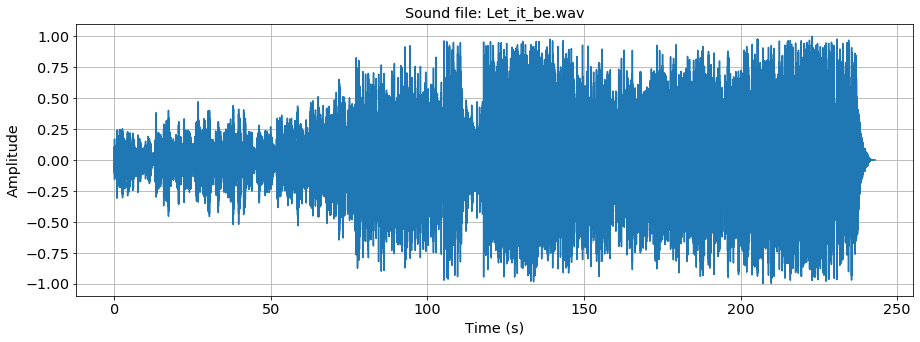

In [0]:
root_path = 'gdrive/My Drive/HT19/MUSIC INFORMATICS/ProjectFiles/'
file_name = 'Let_it_be.wav' 
#file_name = 'Yesterday.mp3'
#file_name = 'Here_Comes_The_Sun.mp3'

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# Sound file
sound_file = pydub.AudioSegment.from_file(str(root_path + file_name))
sound_file = sound_file.set_channels(1) 
fs = sound_file.frame_rate 
samples = sound_file.frame_count()
sound_file = np.divide(sound_file.get_array_of_samples(),sound_file.max_possible_amplitude)

# Plot sound file waveform
plt.plot(np.arange(samples)/fs, sound_file)
plt.title('Sound file: ' + file_name)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.grid()
plt.show()

- **1.** The next step is to compute the **Short-Time Fourier Transform (STFT)**, and to plot the spectral magnitude of the sound file. This is the first step towards computing the chroma features of the audio file. 

- **2.** After the STFT calculation, the next step is to compute the **log-frequency spectrogram** on the spectral magnitude. When using the logarithmic frequency, it is possible to extract MIDI numbers for each time step. 

- **3.** Then, compute the **chroma features (chromagram)** to represent the energy in all 12 pitches (without taking into consideration the octave) from C to B, at every time stamp. 


- **4.** For this chromagram, apply **log compression** to the chroma features, using gamma = 100, and using pitches C to B in the y-axis, instead of 1-12. 

  By computing this, one can extract the 12 dimensional (12 element) chroma vectors. 


- **5.** Lastly, **normalize** the chroma vectors extracted. 


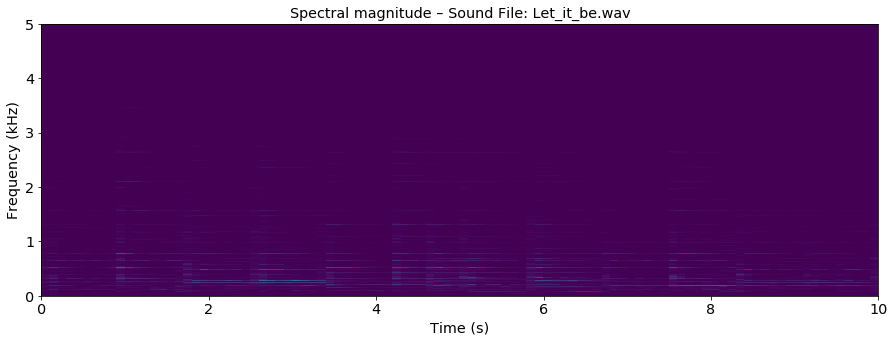

In [0]:
### 1. Spectral magnitude – STFT
window_size_seconds = 200/1000.0
hop_size_seconds = 100/1000.0
overlap_seconds = window_size_seconds - hop_size_seconds # in seconds

window_size_samples = np.ceil(window_size_seconds  * fs)
hop_size_samples = np.ceil(hop_size_seconds * fs)
overlap_samples = window_size_samples - hop_size_samples

f, t, Zxx = signal.stft(sound_file, nperseg=window_size_samples, noverlap=overlap_samples)
abs_Zxx = np.abs(Zxx)/np.max(np.abs(Zxx))

time = t/fs
freq = f*fs/1000

plt.pcolormesh(time, freq, abs_Zxx, vmin=0, vmax=0.5, cmap='viridis')
plt.title('Spectral magnitude – Sound File: ' + file_name)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.ylim(0,5)
plt.xlim(0,10) # Showing the first 10 seconds of selected song
plt.show()

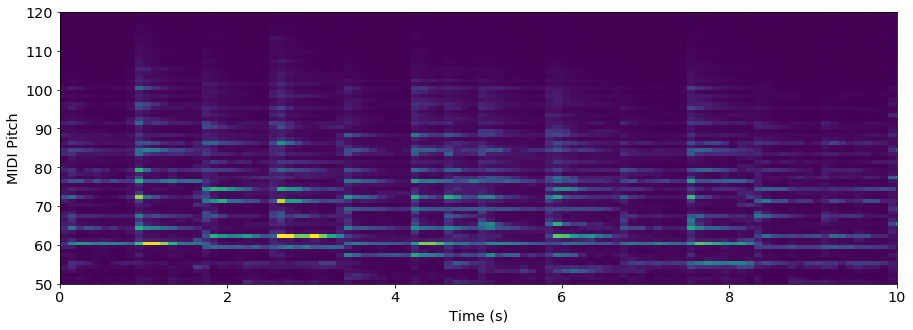

In [0]:
### 2. Log-frequency
f_coeff = np.arange(window_size_samples/2+1) * fs/window_size_samples
f_midi = 2**((np.arange(128)-69)/12) * 440
f_borders = 2**((np.arange(129)-69-0.5)/12) * 440
STFTlogF = np.empty((128,abs_Zxx.shape[1]))

for i in range(128):
  freq_indices = np.logical_and(f_coeff>=f_borders[i], f_coeff<f_borders[i+1])
  
  if np.sum(freq_indices) > 1:
    STFTlogF[i,:] = sum(abs_Zxx[freq_indices,:])
  
  else:
    if np.sum(freq_indices) == 1:
      STFTlogF[i,:] = abs_Zxx[freq_indices,:]
    else:
      STFTlogF[i,:] = 0 
    
fig, ax = plt.subplots()
plt.pcolormesh(time, np.arange(128), STFTlogF, vmin=0, vmax=0.5, cmap='viridis')
plt.ylabel('MIDI Pitch')
plt.xlabel('Time (s)')
plt.ylim(50,120)
plt.xlim(0,10)
plt.show()

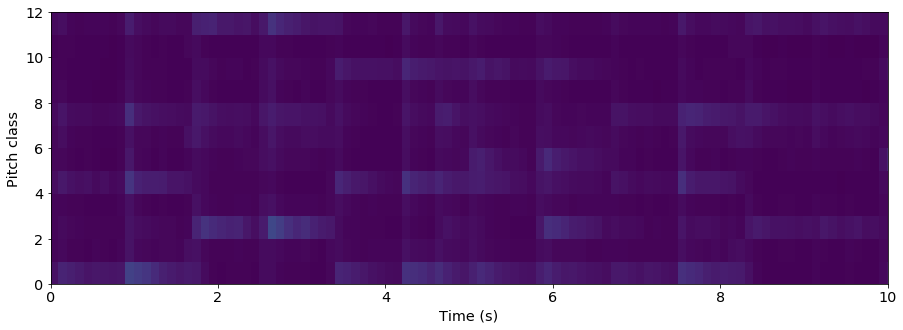

In [0]:
### 3. Chroma
chromagram = np.empty((12,abs_Zxx.shape[1]))

for i in range(12):
  chromagram[i,:] = sum(STFTlogF[((np.arange(128)-i)% 12)==0,:])

fig, ax = plt.subplots()
plt.pcolormesh(time, np.arange(13), chromagram, vmin=0, vmax=np.max(chromagram), cmap='viridis')
plt.ylabel('Pitch class')
plt.xlabel('Time (s)')
plt.xlim(0, 10)
plt.show()

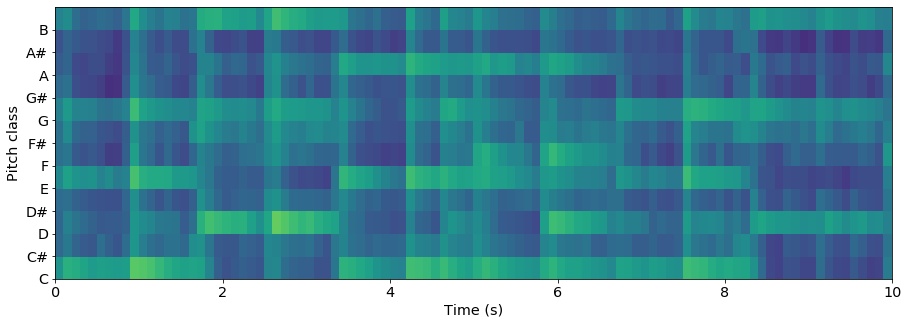

In [0]:
### 4. Apply log compression 
gamma = 100 
chromagram_log = np.log(1+gamma*chromagram)

plt.pcolormesh(time, np.arange(13), chromagram_log, vmin=0, vmax=np.max(chromagram_log), cmap='viridis')
plt.ylabel('Pitch class')
plt.xlabel('Time (s)')
plt.yticks(np.arange(12), ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B'])
plt.xlim(0, 10)
plt.show()

In [0]:
### 5. Normalize chroma vectors
chroma_vector = np.transpose(chromagram_log)

xnorm = chroma_vector/np.linalg.norm(chroma_vector)

print("* Matrix values \n")
print("Chroma matrix shape: " + str(chroma_vector.shape))
print("Chroma vector matrix: \n" + str(chroma_vector) + "\n")
print("Norm matrix shape: " + str(xnorm.shape))
print("Normalized vector matrix: \n" + str(xnorm) + "\n")
print("Example of one norm vector (the second): \n" + str(xnorm[1]) + "\n")
print("Np chroma: " + str(np.linalg.norm(chroma_vector)))
print("Np xnorm: " + str(np.linalg.norm(xnorm)))

* Matrix values 

Chroma matrix shape: (2432, 12)
Chroma vector matrix: 
[[3.27232645e+00 2.12893377e+00 2.09688405e+00 ... 1.84359208e+00
  1.62529480e+00 2.82879606e+00]
 [4.04702434e+00 2.58940386e+00 2.76484133e+00 ... 2.06540848e+00
  2.04005272e+00 3.08517481e+00]
 [3.93312684e+00 2.02334475e+00 2.43474031e+00 ... 1.44055373e+00
  1.78468979e+00 2.26039642e+00]
 ...
 [5.09484584e-02 5.12791992e-02 5.50530430e-02 ... 4.88468593e-02
  3.53953866e-02 4.75919568e-02]
 [5.18335195e-02 4.70949721e-02 5.64616299e-02 ... 4.57119884e-02
  3.51787099e-02 5.11593759e-02]
 [4.53802041e-03 5.14594860e-03 5.03803470e-03 ... 4.17605909e-03
  3.76547434e-03 5.38961766e-03]]

Norm matrix shape: (2432, 12)
Normalized vector matrix: 
[[4.53037414e-03 2.94740352e-03 2.90303227e-03 ... 2.55236207e-03
  2.25014028e-03 3.91632826e-03]
 [5.60290506e-03 3.58490159e-03 3.82778610e-03 ... 2.85945591e-03
  2.82435210e-03 4.27127196e-03]
 [5.44521961e-03 2.80122074e-03 3.37077756e-03 ... 1.99437541e-03
  2.4

- **6.** The next step, that can be seen below, is to create **binary** values through **thresholding** each element in every chroma vector. We do this by setting each normalized element value that is **0.0042 or more, to 1**, and the rest (the elements with **values below 0.0042) to 0**. The limit of 0.0042 is chosen after testing different values as a threshold reference. By this, it is possible to get information about which elements (i.e. which pitches) in every chroma vector has energy enough for it to be seen as representing the pitch in that specific chroma vector. 


In [0]:
### 6. Thresholding
thref = 0.0042

xnorm_global = np.copy(xnorm)
xnorm_global[xnorm_global < thref] = 0

xnorm_binary = np.copy(xnorm_global)
xnorm_binary[xnorm_global >= thref] = 1

print("* Normalized, binary chroma vectors \n")

print("Binary matrix shape: " + str(xnorm_binary.shape))
print("Binary vector matrix: \n" + str(xnorm_binary) + "\n")

print("Examples of vectors")
print("First vector: " + str(xnorm_binary[0]))
print("Second vector: " + str(xnorm_binary[1]))
print("Third vector: " + str(str(xnorm_binary[2]) + "\n"))

* Normalized, binary chroma vectors 

Binary matrix shape: (2432, 12)
Binary vector matrix: 
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Examples of vectors
First vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Second vector: [1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1.]
Third vector: [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]



- **7.** Now, the **sum vector the binary vectors** is calculated, one binary vector for every chroma vector, to one 12 dimensional array. This array/vector is printed below.

- **8.** The last step in the computation to **find the key** of a song is to **plot a histogram** of the summation of arrays created in the previous step. This histogram shows bars for every one of the 12 keys, and uses the sum of each key as the height. By looking at this histogram and analyzing the height of the bars, it is possible to extract which key is estimated for the chosen song.

  To clearify for the user, the predicted key is also printed. 

In [0]:
### 7. Sum to one 12 dimensional vector
vector_sum = sum(xnorm_binary)
print ("Sum of binary vectors: \n" + str(vector_sum))

Sum of binary vectors: 
[2221. 1923. 2120. 1894. 2106. 1956. 1999. 2158. 1761. 1921. 1703. 2087.]


Pitch sum dictionary: 
 {'C': 2221.0, 'C#': 1923.0, 'D': 2120.0, 'D#': 1894.0, 'E': 2106.0, 'F': 1956.0, 'F#': 1999.0, 'G': 2158.0, 'G#': 1761.0, 'A': 1921.0, 'A#': 1703.0, 'B': 2087.0}

*** Predicted key of song: C ***


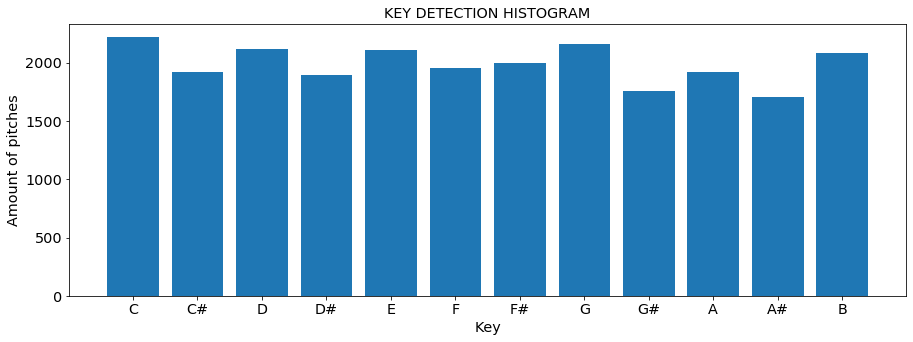

In [0]:
### 8. Histogram of sum vector 
pitch_dictionary = {'C': vector_sum[0],
                    'C#': vector_sum[1],
                    'D': vector_sum[2],
                    'D#': vector_sum[3],
                    'E': vector_sum[4],
                    'F': vector_sum[5],
                    'F#': vector_sum[6],
                    'G': vector_sum[7],
                    'G#': vector_sum[8],
                    'A': vector_sum[9],
                    'A#': vector_sum[10],
                    'B': vector_sum[11]}

print("Pitch sum dictionary: \n " + str(pitch_dictionary) + "\n")

# To print the estimated key
d_value = list(pitch_dictionary.values())
d_key = list(pitch_dictionary.keys())

max_key = d_key[d_value.index(max(d_value))]

print("*** Predicted key of song: " + str(max_key) + " ***")

plt.bar(pitch_dictionary.keys(), pitch_dictionary.values(), label = pitch_dictionary.values())
plt.title('KEY DETECTION HISTOGRAM')
plt.ylabel('Amount of pitches')
plt.xlabel('Key')
plt.show()

- Lastly, the code is tested with two additional songs, three in total, to make a short test of the reliability of the computation. All three songs are from The Beatles, and [2], and its metadata was used to check if the estimated key was correct or not. This was checked by changing the file name at the very top of the project to the other songs. 


**3. Results**

The results of the algorithm testings were:

- Song 'Let it be' – Correct key: C 
- Song 'Yesterday' – Correct key: F
- Song 'Here comes the sun' – Wrong key: estimated A, but should be Ab

**Discussion & Conclusion**

My implementation shows to not correctly estimate a songs key in every case. In this particular case, having three songs as our data, 2/3 had their key correctly estimated, while 1/3 were not correctly estimated, though not far from the correct answer (A vs Ab). This is generally a good reliability, 2/3, but the low amount of data is not enough to express any conclusions about the reliability of the algorithm, as three data samples it too little. 

A solution to this problem would be to test with a bigger amount of data (songs), to really get a sense of the robustness of the code. 

I believe that this implementation is though a bit basic and could be improved in several areas. The code could be coded to e.g. be more robust, and not give any wrong estimations, even though 100% correct estimations might be very hard to implement. And there is of course a lot more to explore and do code to better estimate the key of a song.

For further work, it would be great to make the code on a higher level to better detect keys from song files. 


**References**

[1] Meinard Müller: **Fundamentals of Music Processing.** Springer Verlag, 2015. 

[2] Meinard Müller and Frank Zalkow: **FMP Notebooks: Educational Material for Teaching and Learning Fundamentals of Music Processing.** Proceedings of the International Conference on Music Information Retrieval (ISMIR), Delft, The Netherlands, 2019. (https://www.audiolabs-erlangen.de/resources/MIR/FMP/C0/C0.html)